In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
import jieba.analyse
from keras.models import Model
from keras.layers import Input, Flatten, concatenate, Dense
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support

In [36]:
def trading_strategy(company, tick, periods, sigma, usecols=['證券代碼', '年月日', '收盤價(元)', '成交量(千股)']):
    price = pd.DataFrame([], columns=usecols)
    for y in range(2016, 2019):
        price = pd.concat([price, pd.read_csv('./data/TWSE' + str(y) + '.csv', usecols=usecols)])
    price[['stock_no', 'stock_name']] = price['證券代碼'].str.split(expand=True)
    price = price[(price.stock_name == company) & (price.stock_no == tick)].sort_values('年月日').reset_index(drop=True)
    price['年月日'] = pd.to_datetime(price['年月日'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
    price['收盤價(元)'] = price['收盤價(元)'].str.replace(',', '').astype(float)
    price['成交量(千股)'] = price['成交量(千股)'].str.replace(',', '').astype(float)
    price['return'] = price['收盤價(元)'].pct_change(periods=periods)
    price['volume_change'] = price['成交量(千股)'].pct_change(periods=periods)
    price['label'] = np.select([price['return'] <= -sigma, price['return'] >= sigma], [-1, 1], default=0)
    price['volume_label'] = np.select([price['volume_change'] <= -sigma*50, price['volume_change'] >= sigma*50], [-1, 1], default=0)
    price.label = np.concatenate([price.label.iloc[periods:].values, [0]*periods])
    price.volume_label = np.concatenate([price.volume_label.iloc[periods:].values, [0]*periods])
    
    idx = np.where(price.label != 0)[0]   # 反轉點
    vol_idx = np.where(price.volume_label != 0)[0]   # 交易量判斷的反轉點
    fig = plt.figure(figsize=(10, 4))
    plt.plot(price['收盤價(元)'].values, c='k', alpha=0.7, zorder=0)
    plt.scatter(idx, price.loc[idx, '收盤價(元)'], c='r', s=15, alpha=0.7, zorder=2)
    plt.scatter(vol_idx, price.loc[vol_idx, '收盤價(元)'], c='lime', s=15, alpha=0.7, zorder=1)
    plt.show()
    print('Total return:', np.sum(price['收盤價(元)']*price.label))
    return price

def get_company_data(company, tick, usecols=['post_time', 'title', 'content']):
    bbs = pd.read_csv('./data/bbs_utf8.csv', usecols=usecols)
    forum = pd.read_csv('./data/forum_utf8.csv', usecols=usecols)
    news = pd.read_csv('./data/news_utf8.csv', usecols=usecols)  # no comment_count
    
    bbs = bbs[~bbs.content.isnull() & bbs.content.str.contains('|'.join([company, tick]))]
    forum = forum[~forum.content.isnull() & forum.content.str.contains('|'.join([company, tick]))]
    news = news[~news.content.isnull() & news.content.str.contains('|'.join([company, tick]))]
    
    company_data = pd.concat([bbs, forum, news]).sort_values('post_time').reset_index(drop=True)
    company_data.post_time = pd.to_datetime(company_data.post_time, format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
    return company_data

def get_keywords(data, topK=2000):
    data.content = data.content.str.replace(u'[(<BR>)(\n)(\u3000)，。、：；！？％／（）《》「」『』【】〖〗,.:;!?%&#$@^~…●▲◆★▌╰╮╭╯`˙"‘’“”=═(){}<>|║\'*+-/[\\]^_ ]+', '')
    seg_list = data.content.apply(lambda x: jieba.lcut(x))
    keywords, weights = zip(*jieba.analyse.extract_tags(' '.join(sum(seg_list.tolist(), [])), topK=topK, withWeight=True))
    id2word_dict = dict(zip(np.arange(len(keywords)) + 1, keywords))
    word2id_dict = {v: k for k, v in id2word_dict.items()}
    
    seg_list = seg_list.apply(lambda x: list(filter(lambda y: y is not None, map(word2id_dict.get, x))))
    seg_list = pd.concat([data.post_time, seg_list], axis=1).groupby('post_time', as_index=False).agg(sum)
    seg_list.content = seg_list.content.apply(lambda x: pd.Series(x).drop_duplicates().tolist())
    min_len = min(map(len, seg_list.content))
    return min_len, seg_list, word2id_dict

def load_data(seg_list, company_price, k_keywords, split):
    inputs = np.array(seg_list.content.apply(lambda x: x[:k_keywords] if len(x) >= k_keywords else x+[0]*(k_keywords-len(x))).values.tolist())
    inputs = inputs[seg_list[seg_list.post_time.isin(company_price['年月日'])].index]
    output = company_price[~company_price['年月日'].isin(np.setdiff1d(company_price['年月日'], seg_list.post_time).tolist())].label + 1
    class_up, class_na, class_down = np.where(output == 2)[0].shape[0], np.where(output == 1)[0].shape[0], np.where(output == 0)[0].shape[0]
    print('向上反轉點:', class_up, '沒有影響:', class_na, '向下反轉點:', class_down)
    
    split = int(inputs.shape[0] * split)
    train_x, train_y, train_y_onehot, test_x, test_y, test_y_onehot = inputs[:-split], output[:-split], to_categorical(output, num_classes=3)[:-split], inputs[-split:], output[-split:], to_categorical(output, num_classes=3)[-split:]
    class_weight = {0: class_na*class_up, 1: class_down*class_up, 2: class_down*class_na}
    min_v = min(class_weight.values())
    class_weight.update((k, v//min_v) for k, v in class_weight.items())
    print('class weight:', class_weight)
    return train_x, train_y, train_y_onehot, test_x, test_y, test_y_onehot, class_weight

def build_model(input_shape):
    inputs = Input(shape=(input_shape,), name='news_input')
    wordEmbed = Embedding(topK, 4, name='word_embed')(inputs)
    wordEmbed = Flatten(name='word_flat')(wordEmbed)
    x = Dense(32, activation='softmax', name='dense_1')(wordEmbed)
    x = Dense(16, activation='softmax', name='dense_2')(x)
    x = Dense(8, activation='softmax', name='dense_3')(x)
    output = Dense(3, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    return model

def evaluate(model, history, test_x, test_y):
    fig = plt.figure(figsize=(10, 4))
    for i, mode in enumerate(['loss', 'sparse_categorical_accuracy']):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[mode], label='train')
        plt.plot(history.history['val_'+mode], '--', label='valid')
        plt.xlabel('epoch')
        plt.ylabel(mode)
        plt.legend(loc='best')
    plt.show()

    predict = np.argmax(model.predict(test_x), axis=1)
    precision, recall, fscore, _ = precision_recall_fscore_support(predict, test_y)
    print('各類別 precision:', precision, '\n各類別 recall:', recall)
    precision, recall, fscore, _ = precision_recall_fscore_support(predict, test_y, average='micro')   # average = micro or weighted
    print('precision: %.4f\nrecall: %.4f' % (precision, recall))

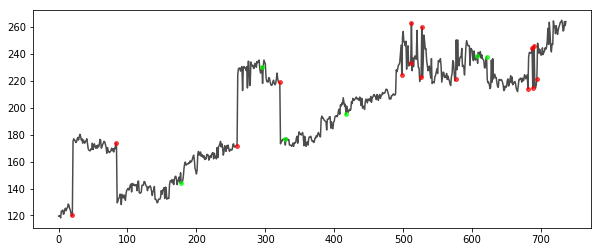

Total return: 437.31999999999994
['2017-04-28'] 沒有新聞
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
news_input (InputLayer)      (None, 10)                0         
_________________________________________________________________
word_embed (Embedding)       (None, 10, 4)             8000      
_________________________________________________________________
word_flat (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
output (Dense)         

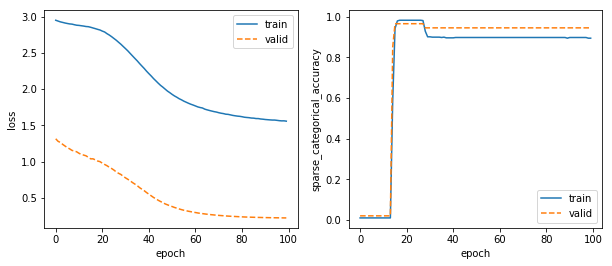

各類別 precision: [0.         0.97887324 0.        ] 
各類別 recall: [0.         0.96527778 0.        ]
precision: 0.9456
recall: 0.9456


/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [38]:
company = '台積電'
tick = '2330'
periods = 1
sigma = 0.1
topK = 2000
k_keywords = 10
epochs = 100
split = 0.2

company_price = trading_strategy(company, tick, periods, sigma)
company_data = get_company_data(company, tick)
print(np.setdiff1d(company_price['年月日'], company_data.post_time).tolist(), '沒有新聞')
# min_len, seg_list, word2id_dict = get_keywords(company_data, topK=topK)

model = build_model(k_keywords)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
train_x, train_y, train_y_onehot, test_x, test_y, test_y_onehot, class_weight = load_data(seg_list, company_price, k_keywords, split)
history = model.fit(train_x, train_y, epochs=epochs, batch_size=16, validation_data=(test_x, test_y), verbose=2, class_weight=class_weight)
evaluate(model, history, test_x, test_y)

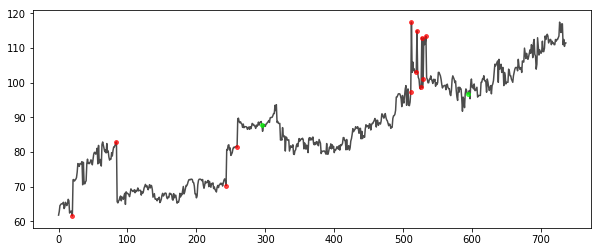

Total return: 71.36999999999998
['2017-04-27', '2017-10-13', '2017-10-19', '2017-11-27', '2018-02-01', '2018-02-09', '2018-03-15', '2018-04-19', '2018-08-08', '2018-08-09'] 沒有新聞


In [39]:
company = '台塑'
tick = '1301'
periods = 1
sigma = 0.1
topK = 2000
k_keywords = 10
epochs = 50
split = 0.2

company_price = trading_strategy(company, tick, periods, sigma)
company_data = get_company_data(company, tick)
print(np.setdiff1d(company_price['年月日'], company_data.post_time).tolist(), '沒有新聞')
# min_len, seg_list, word2id_dict = get_keywords(company_data, topK=topK)

# model = build_model(k_keywords)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# train_x, train_y, test_x, test_y, class_weight = load_data(seg_list, company_price, k_keywords, split)
# history = model.fit(train_x, train_y, epochs=epochs, batch_size=16, validation_data=(test_x, to_categorical(test_y, num_classes=3)), verbose=2, class_weight=class_weight)
# evaluate(model, history, test_x, test_y)

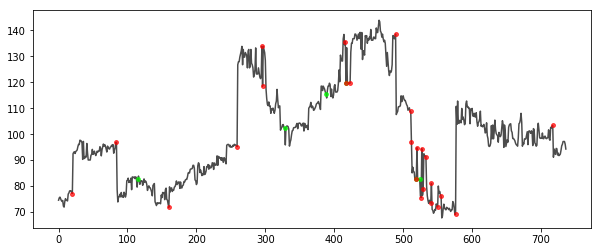

Total return: -198.49
[] 沒有新聞


In [40]:
company = '鴻海'
tick = '2317'
periods = 1
sigma = 0.1
topK = 2000
k_keywords = 10
epochs = 50
split = 0.2

company_price = trading_strategy(company, tick, periods, sigma)
company_data = get_company_data(company, tick)
print(np.setdiff1d(company_price['年月日'], company_data.post_time).tolist(), '沒有新聞')
# min_len, seg_list, word2id_dict = get_keywords(company_data, topK=topK)

# model = build_model(k_keywords)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# train_x, train_y, test_x, test_y, class_weight = load_data(seg_list, company_price, k_keywords, split)
# history = model.fit(train_x, train_y, epochs=epochs, batch_size=16, validation_data=(test_x, to_categorical(test_y, num_classes=3)), verbose=2, class_weight=class_weight)
# evaluate(model, history, test_x, test_y)

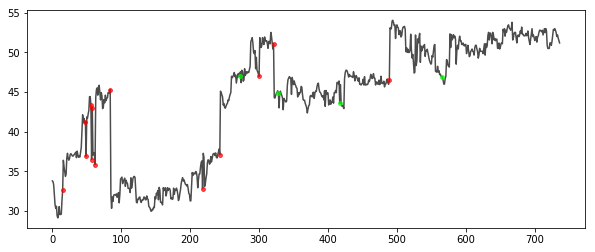

Total return: 81.18
['2016-11-02', '2017-07-27', '2017-08-01', '2017-09-13', '2017-09-30', '2017-10-17', '2018-01-31', '2018-02-01', '2018-02-02'] 沒有新聞


In [41]:
company = '國泰金'
tick = '2882'
periods = 1
sigma = 0.1
topK = 2000
k_keywords = 10
epochs = 50
split = 0.2

company_price = trading_strategy(company, tick, periods, sigma)
company_data = get_company_data(company, tick)
print(np.setdiff1d(company_price['年月日'], company_data.post_time).tolist(), '沒有新聞')
# min_len, seg_list, word2id_dict = get_keywords(company_data, topK=topK)

# model = build_model(k_keywords)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# train_x, train_y, test_x, test_y, class_weight = load_data(seg_list, company_price, k_keywords, split)
# history = model.fit(train_x, train_y, epochs=epochs, batch_size=16, validation_data=(test_x, to_categorical(test_y, num_classes=3)), verbose=2, class_weight=class_weight)
# evaluate(model, history, test_x, test_y)

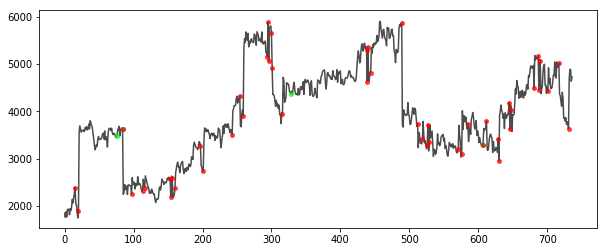

Total return: -3236.609999999998
['2018-01-30', '2018-01-31', '2018-02-02'] 沒有新聞


In [42]:
company = '大立光'
tick = '3008'
periods = 1
sigma = 0.1
topK = 2000
k_keywords = 10
epochs = 50
split = 0.2

company_price = trading_strategy(company, tick, periods, sigma)
company_data = get_company_data(company, tick)
print(np.setdiff1d(company_price['年月日'], company_data.post_time).tolist(), '沒有新聞')
# min_len, seg_list, word2id_dict = get_keywords(company_data, topK=topK)

# model = build_model(k_keywords)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# train_x, train_y, test_x, test_y, class_weight = load_data(seg_list, company_price, k_keywords, split)
# history = model.fit(train_x, train_y, epochs=epochs, batch_size=16, validation_data=(test_x, to_categorical(test_y, num_classes=3)), verbose=2, class_weight=class_weight)
# evaluate(model, history, test_x, test_y)